In [30]:
!pip install mecab
!pip install ipadic

In [31]:
import re
import ipadic
import subprocess
import unicodedata
import pandas as pd
import MeCab
from wordcloud import WordCloud

In [32]:
# データの読み込み
df = pd.read_csv("./sample_data.csv")
# ユニコード正規化とアルファベットの小文字統一
df.text = df.text.str.normalize("NFKC").str.lower()
# 改行コードを取り除く
df.text = df.text.str.replace("\n", " ")
# エラーになる文字があるので取り除く (ライブドアニュースコーパス使う場合だけの処理。普通は不要)
df.text = df.text.str.replace("\u2028", "")

# 辞書のパス取得
tagger = MeCab.Tagger(ipadic.MECAB_ARGS)

# ひらがなのみの文字列にマッチする正規表現
kana_re = re.compile("^[ぁ-ゖ]+$")

# 分かち書きして、ひらがな以外を含む 名詞/動詞/形容詞 を返す関数
def mecab_tokenizer(text):
    # 分かち書き
    parsed_lines = tagger.parse(text).splitlines()[:-1]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]
    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 名詞/動詞/形容詞に絞り込み
    target_pos = ["名詞", "動詞", "形容詞"]
    token_list = [t for t, p in zip(token_list, pos) if (p in target_pos)]
    # ひらがなのみの単語を除く
    token_list = [t for t in token_list if not kana_re.match(t)]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]
    # 半角スペースを挟んで結合する。
    result = " ".join(token_list)
    # 念のためもう一度ユニコード正規化
    result = unicodedata.normalize("NFKC", result)
    return result
    

In [33]:
# 形態素解析
df["tokens"] = df.text.apply(mecab_tokenizer)
# wordcloud入力データ用に連結する
text_data = " ".join(df["tokens"])

# ワードクラウドのオブジェクト生成
wc = WordCloud(
        width=600,  # 幅
        height=400,  # 高さ
        prefer_horizontal=0.9,  # 横書きで配置することを試す確率 (デフォルト0.9)
        background_color='white',  # 背景色
        include_numbers=False,  # 数値だけの単語を含まない
        colormap='tab20',  # 文字色のカラーマップ指定
        regexp=r"\w{2,}",  # 2文字以上の単語のみ含む
        relative_scaling=1,  # 頻度のみで文字サイズを決める
        collocations=False,  # bi-gramを考慮しない
        max_font_size=60,  # 最大フォントサイズ
        random_state=42,  # 乱数の初期値
    ).generate(text_data)

# この時点で作成できたwordcloudを確認する場合は以下の関数を実行。
ex_text = wc.to_svg()
ex_img = wc.to_image()
# 出力省略


In [34]:
ex_text

'<svg xmlns="http://www.w3.org/2000/svg" width="600" height="400">\n<style>text{font-family:\'Droid Sans Mono\';font-weight:normal;font-style:normal;}</style>\n<rect width="100%" height="100%" style="fill:white"></rect>\n<text transform="translate(186,57)" font-size="60" style="fill:rgb(127, 127, 127)">日本人</text>\n<text transform="translate(371,94)" font-size="24" style="fill:rgb(127, 127, 127)">潜伏</text>\n<text transform="translate(100,285)" font-size="24" style="fill:rgb(174, 199, 232)">期間</text>\n<text transform="translate(407,35)" font-size="24" style="fill:rgb(174, 199, 232)">発熱</text>\n<text transform="translate(191,318)" font-size="24" style="fill:rgb(31, 119, 180)">日本</text>\n<text transform="translate(133,344)" font-size="24" style="fill:rgb(127, 127, 127)">入場</text>\n<text transform="translate(93,253)" font-size="24" style="fill:rgb(196, 156, 148)">皆さま</text>\n<text transform="translate(147,22)" font-size="24" style="fill:rgb(199, 199, 199)">買う</text>\n<text transform="transl

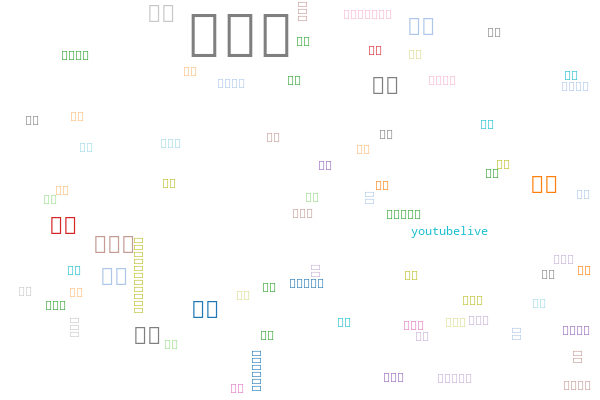

In [35]:
ex_img